In [59]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from datetime import datetime as dt

# Load Data

In [24]:
DATASET = 'wsc-spacy'
wd = os.path.dirname('__file__')
f_name = f'{DATASET}_RESULTS.csv'
results = pd.read_csv(os.path.join(f_name))

#f_name_MCMLM_PSPAN = 'raw_results_wsccross_wscspacy_MCMLM_PSPAN.csv'
#f_name_OTHERS = 'wsc-spacy.csv'

#results1 = pd.read_csv(os.path.join(wd, f_name_MCMLM_PSPAN))
#results2 = pd.read_csv(os.path.join(wd, f_name_OTHERS))


#results = pd.concat([results1, results2]).reset_index()

# Data Exploration

In [25]:
print(list(results.columns.values))
print(f"\n {results.shape}")

framings = results['framing'].unique()
print(framings)

['Unnamed: 0', 'level_0', 'index', 'dataset', 'framing', 'learning_rate', 'batch_size', 'max_epochs', 'seed', 'best_val_accuracy', 'exp_name', 'best_iter', 'current_iter', 'total_iter', 'early_stop']

 (135, 15)
['MC-MLM' 'P-SPAN' 'MC-SENT' 'MC-SENT-PAIR' 'MC-SENT-PLOSS' 'P-SENT'
 'MC-SENT-SCALE']


In [26]:
lr_c = [1e-5, 2e-5, 3e-5]
bs_c = [8, 16, 32, 64]
ep_c = [10, 20, 40]
data = 'wsc-spacy'

lr = 'learning_rate'
bs = 'batch_size'
ep = 'max_epochs'
d = 'dataset'

keep = []

frames = {key:0 for key in framings}

for label, row in results.iterrows():
    if (row['dataset'] == data and
        row['learning_rate'] in lr_c and
        row['batch_size'] in bs_c and
        row['max_epochs'] in ep_c):
        keep.append(label)
        frames[row['framing']] += 1

print(f"Kept {len(keep)}")
print(frames)

Kept 135
{'MC-MLM': 31, 'P-SPAN': 37, 'MC-SENT': 13, 'MC-SENT-PAIR': 15, 'MC-SENT-PLOSS': 13, 'P-SENT': 16, 'MC-SENT-SCALE': 10}


# Switch from Markdown to Save

wd = os.path.dirname('__file__')
out_results = os.path.join(wd, f"{DATASET}_RESULTS.csv")
framing_counts = os.path.join(wd,f"{DATASET}_FRAMING_COUNTS.json")

f_results = results.loc[keep,:].reset_index()
f_results.to_csv(out_results)

with open(framing_counts, 'w') as f:
    f.write(json.dumps(framing_counts))

# Analyze

In [169]:
def make_box_plots(data,
                   labels, 
                   key_frame = 'framing',
                   key_acc = 'best_val_accuracy',
                   x_size = 10,
                   y_size = 5,
                   y_min = 55,
                   y_max = 100,
                   y_tick = 15,
                   y_offset = 1,
                   x_offset = .8,
                   splines_offset = 10,
                   bar_trans = 0.3,
                   colors = ['darkgrey',
                             'peachpuff',
                             'burlywood',
                             'gold',
                             'lightgreen',
                             'skyblue',
                             'plum',
                            ],
                   bar_colors = True,
                   bar_labels = True,
                   adjusted_axes = True,
                   title = None,
                   showfliers = True,
                   notch = False,
                  ):
    
    all_scores = []
    max_scores = []
    for label in labels:
        dist = data.loc[data[key_frame]==label,key_acc]*100
        all_scores.append(dist)
        max_scores.append(max(dist))
    
    fig, ax = plt.subplots(figsize=(x_size, y_size))
    if not title is None:
        ax.set_title(title)
    
    ax.set_ylim(y_min, y_max)
    ax.set_yticks(np.arange(y_min, y_max+1, y_tick))
    ax.set_xticklabels(labels)
    
    if adjusted_axes:
        # Adjust plot borders
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_position(('outward', splines_offset))
        ax.spines['bottom'].set_position(('outward', splines_offset))
    
    ticks = np.arange(len(labels))+1
    
    if not bar_colors:
        colors = None
    
    ax.bar(ticks, max_scores, color = colors, alpha=bar_trans)
    ax.boxplot(all_scores, notch = notch, showfliers = showfliers)
    
    if bar_labels:
        for i, v in enumerate(max_scores):
            ax.text(i + x_offset, v + y_offset, "{:.2f}%".format(v))
    
    # Adjust layout
    fig.tight_layout()
    
    return fig

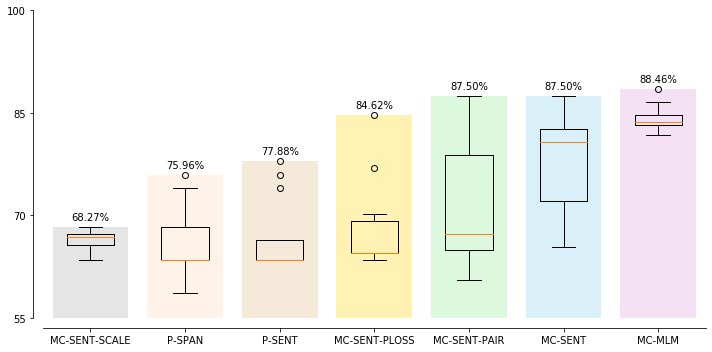

In [170]:
ordered_framings = ['MC-SENT-SCALE',
                   'P-SPAN',
                   'P-SENT',
                   'MC-SENT-PLOSS',
                   'MC-SENT-PAIR',
                   'MC-SENT',
                   'MC-MLM']

f = make_box_plots(results,
                   ordered_framings,
                   bar_colors = True,
                   bar_labels = True,
                   adjusted_axes = True,
                   title = None,
                   showfliers = True,
                   notch = False,
                  )

In [176]:
def get_stats(data,
              labels,
              key_frame = 'framing',
              key_acc = 'best_val_accuracy',
             ):
    results = {label : {} for label in labels}
    
    for label, value in results.items():
        dist = data.loc[data[key_frame]==label,key_acc]
        
        value['mean'] = dist.mean()
        value['std'] = dist.std()
        value['medium'] = dist.median()
        value['1Q'] = dist.quantile(q=0.25)
        value['3Q'] = dist.quantile(q=0.75)
    
    return results

In [177]:
stats = get_stats(results,
                  ordered_framings,
                 )

print(stats)

{'MC-SENT-SCALE': {'mean': 0.66538461539, 'std': 0.01489608980943598, 'medium': 0.6682692308, '1Q': 0.656249999975, '3Q': 0.6730769231}, 'P-SPAN': {'mean': 0.6587837837837837, 'std': 0.04547565415603977, 'medium': 0.6346153846153846, '1Q': 0.6346153846153846, '3Q': 0.6826923076923077}, 'P-SENT': {'mean': 0.66406249999375, 'std': 0.04921333199673672, 'medium': 0.6346153846, '1Q': 0.6346153846, '3Q': 0.6634615385}, 'MC-SENT-PLOSS': {'mean': 0.6775147928846154, 'std': 0.06373476835109211, 'medium': 0.6442307692, '1Q': 0.6442307692, '3Q': 0.6923076923}, 'MC-SENT-PAIR': {'mean': 0.7121794871933333, 'std': 0.09226093901097329, 'medium': 0.6730769231, '1Q': 0.64903846155, '3Q': 0.7884615384999999}, 'MC-SENT': {'mean': 0.7758875739615385, 'std': 0.07091790136107703, 'medium': 0.8076923077, '1Q': 0.7211538462, '3Q': 0.8269230769}, 'MC-MLM': {'mean': 0.8415012406947892, 'std': 0.015278271830457204, 'medium': 0.8365384615384616, '1Q': 0.8317307692307692, '3Q': 0.8461538461538461}}


# Save Stuff

In [178]:
wd = os.path.dirname('__file__')
now = dt.now().strftime("%Y%m%d_%H%M")
plot_name = os.path.join(wd, f"{DATASET}_plot_{now}.png")
stats_name = os.path.join(wd, f"{DATASET}_stats_{now}.json")

f.savefig(plot_name)
with open(stats_name, 'w') as f:
    f.write(json.dumps(stats))